# Import packages

In [1]:
from array import array
import csv
import itertools
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import astroML.density_estimation as aml
import astroML.plotting as amlplot
import iminuit
import pandas as pd
import root_pandas as rpd
import ROOT

mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 16}) 
mpl.rcParams.update({'ytick.labelsize': 16}) 

# plt.style.use('presentation')

Welcome to JupyROOT 6.09/01


# Get data from Ntuples
## Get dataframes from TTrees

In [2]:
def getData(inputFiles):
    maxEvents = 500000
    
    columns = []
    columns.append('cluster_pt')
    columns.append('cluster_eta')
    columns.append('cluster_phi')
    columns.append('cluster_e_cross')
    columns.append('cluster_e')
    columns.append('cluster_ncell')
    columns.append('cluster_iso_tpc_04')
    columns.append('cluster_iso_its_04')
    columns.append('cluster_frixione_tpc_04_02')
    columns.append('cluster_frixione_its_04_02')
    columns.append('cluster_nlocal_maxima')
    columns.append('cluster_b5x5_lin')
    columns.append('cluster_b5x5')
    columns.append('cluster_NN1')
    columns.append('cluster_NN2')
    columns.append('cluster_Lambda')
    columns.append('cluster_minMass')
    columns.append('cluster_SuperModule')
    
    start = time.time()
    dataframe = rpd.read_root(inputFiles, columns=columns, flatten=True, stop=maxEvents)
    end = time.time()
    print 'Processed', ','.join(inputFiles), 'in', end-start, 'seconds'
        
    return dataframe

## Define cuts

In [4]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe

def applyCuts(fullDataframe): 
 
    fullDataframe.eval('cluster_ecross_over_e = cluster_e_cross/cluster_e', inplace=True)
    dataframe = fullDataframe
  
    dataframe.hist(column='cluster_SuperModule',bins=40)
    #dataframe = applyCut(dataframe, 'cluster_SuperModule!=3', 'Remove SM#3:')
    #dataframe = applyCut(dataframe, 'cluster_SuperModule!=6', 'Remove SM#6:')
    #dataframe = applyCut(dataframe, 'cluster_SuperModule!=7', 'Remove SM#7:')
    #dataframe = applyCut(dataframe, 'cluster_SuperModule!=14', 'Remove SM#14:')
    #dataframe = applyCut(dataframe, 'cluster_SuperModule<10', 'Remove SM>10:')
  # dataframe.hist(column='cluster_SuperModule',bins=40)
    
    dataframe = applyCut(dataframe, 'cluster_pt>10.0', 'pt >10.0  GeV :')
    dataframe = applyCut(dataframe, 'cluster_pt<100.0', 'pt <100.0 GeV  :')
   
    dataframe.hist(column='cluster_ecross_over_e',bins=100, range=(0.0,1.0))
    dataframe = applyCut(dataframe, 'cluster_ecross_over_e>0.05', 'ecross/e > 0.05 :')
    dataframe.hist(column='cluster_ecross_over_e',bins=100, range=(0.0,1.0))

    dataframe.hist(column='cluster_ncell',bins=100)
    dataframe = applyCut(dataframe, 'cluster_ncell>2', 'ncell > 2:')

    dataframe = applyCut(dataframe, 'cluster_NN1>0 and cluster_NN1<1.0', '0<NN1<1.0 :')
    dataframe = applyCut(dataframe, 'cluster_NN2>0 and cluster_NN2<1.0', '0<NN2<1.0 :')
    dataframe = applyCut(dataframe, 'cluster_nlocal_maxima<2', 'Local Maxima < 2 :')
 
    dataframe.hist(column='cluster_frixione_its_04_02', range=(-5,10), bins=100)
    dataframe.hist(column='cluster_iso_its_04', range=(-5,10), bins=100)
    
    dataframe.hist(column='cluster_frixione_its_04_02', range=(-5,10), bins=100, cumulative=True, normed=True)
    applyCut(dataframe, 'cluster_frixione_its_04_02<2', 'isolation < 2 GeV:')
    
    dataframe.hist(column='cluster_eta', bins=100)
    dataframe.hist(column='cluster_phi', bins=100)
    #dataframe.plot.hexbin(x='cluster_eta', y='cluster_phi', gridsize=150, cmap='inferno', bins='log')
    #dataframe = applyCut(dataframe, 'cluster_SuperModule<10', 'Remove SM#>10:')
    #dataframe.plot.hexbin(x='cluster_eta', y='cluster_phi', gridsize=150, cmap='inferno', bins='log')
    dataframe = applyCut(dataframe, 'cluster_SuperModule!=3', 'Remove SM#!=3:')
    #dataframe.plot.hexbin(x='cluster_eta', y='cluster_phi', gridsize=150, cmap='inferno', bins='log', title='No SM#3')
    #dataframe = applyCut(dataframe, 'cluster_SuperModule!=5', 'Remove SM#!=5:')
    #dataframe.plot.hexbin(x='cluster_eta', y='cluster_phi', gridsize=100, cmap='inferno', bins='log', title='No SM#5')
    dataframe = applyCut(dataframe, 'cluster_SuperModule!=7', 'Remove SM#!=7:')
    #dataframe.plot.hexbin(x='cluster_eta', y='cluster_phi', gridsize=150, cmap='inferno', bins='log', title='No SM#7')
    #dataframe = applyCut(dataframe, 'cluster_SuperModule!=6', 'Remove SM#!=6:')
    #dataframe.plot.hexbin(x='cluster_eta', y='cluster_phi', gridsize=150, cmap='inferno', bins ='log',title='No SM#6')
    #dataframe.hist(column='cluster_SuperModule',bins=40)
    #dataframe.hist(column='cluster_eta', bins=100)
    #dataframe.hist(column='cluster_phi', bins=100)
    
    
    isodata = applyCut(dataframe, 'cluster_frixione_its_04_02<2', 'isolation < 2 GeV:')
    isodata.hist(column='cluster_ecross_over_e',bins=100, range=(0.0,1.0))
    isodata.hist(column='cluster_NN1',bins=400, range=(0.0,1.0), normed=True)
    isodata.hist(column='cluster_Lambda',bins=400, range=(0.0,1.0), normed=True)
    isodata.hist(column='cluster_b5x5_lin',bins=400, range=(0.0,1.0), normed=True)
    #   dataframe.hist(column='cluster_frixione_its_04_02', range=(-5,25), bins=100)
    #dataframe = applyCut(dataframe, 'cluster_Lambda<2.0', 'lambda < 2.0:')
    return dataframe

# Build templates from dataframes

In [5]:
def getIsoSplitHists(data, bins, isoCut, nonisoCuts, var, isovar, varRange):
    hfull, binEdges = np.histogram(data[var], bins, range=varRange)
    hiso, _ = np.histogram(data.query('%s<%f'%(isovar,isoCut))[var], binEdges, range=varRange)
    hnoniso, _ = np.histogram(data.query('%s>%f and %s<%f'%(isovar,nonisoCuts[0],isovar, nonisoCuts[1]))[var], binEdges, range=varRange)

    return hfull, hiso, hnoniso, binEdges

#it was 10-15 GeV
def getTemplates(dataHists, mcHists, bins, isocut=2, nonisocuts=(4,15), var='cluster_NN1', isovar='cluster_frixione_its_04_02', varRange=(0.0, 1.0)):
    _, dataiso, datanoniso, binEdges = getIsoSplitHists(dataHists, bins, isocut, nonisocuts, var, isovar, varRange)
    signalmc, _ = np.histogram(mcHists[var], binEdges, range=varRange)

    dataisoerr = np.sqrt(dataiso)
    datanonisoerr = np.sqrt(datanoniso)
    signalmcerr = np.sqrt(signalmc)
    
    return dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges

# Define template fit and purity

In [6]:
def haveSameLength(*args):
    n = len(args[0])
    return all(len(l) == n for l in args)

def normalize(x):
    return np.array(x, dtype='f')/np.sum(x)

def getBinRange(binEdges, valuemin, valuemax):
    binmin = min([i for i, edge in enumerate(binEdges) if edge >= valuemin])
    binmax = max([i for i, edge in enumerate(binEdges) if edge <= valuemax])
    return binmin, binmax
    
def getPurity(signal, bkg, binEdges, frac, purityMin, purityMax, returnRange=False):
    # signal and bkg should be normalized to 1
    pmin, pmax = getBinRange(binEdges, purityMin, purityMax)
    purity = np.sum(frac*signal[pmin:pmax])/(np.sum([(1-frac)*bkg[pmin:pmax], frac*signal[pmin:pmax]]))
    
    if returnRange:
        return purity, pmin, pmax
    else:
        return purity

class TemplateFit:
    def __init__(self, data, dataerr, signal, signalerr, bkg, bkgerr, binEdges, fitRange=None, verbosity=1):       
        if not haveSameLength(data, dataerr, signal, signalerr, bkg, bkgerr, binEdges[1:]):
            raise ValueError('Inputs do not have the same length (binEdges should have 1 more than the rest)')
        
        self.data = np.array(data, dtype='f')
        self.dataerr = np.array(dataerr, dtype='f')
        self.inputSignal = np.array(signal, dtype='f')
        self.inputSignalerr = np.array(signalerr, dtype='f')
        self.inputBkg = np.array(bkg, dtype='f')
        self.inputBkgerr = np.array(bkgerr, dtype='f')
        self.binEdges = binEdges
        if fitRange:
            self.fitRange = getBinRange(binEdges, *fitRange)
        else:
            self.fitRange = (0, None)
        
        self.signal = self.inputSignal/np.sum(self.inputSignal)
        self.signalerr = self.inputSignalerr/np.sum(self.inputSignal)
        self.bkg = self.inputBkg/np.sum(self.inputBkg)
        self.bkgerr = self.inputBkgerr/np.sum(self.inputBkg)
        self.binCenters = np.array([(hedge+ledge)/2.0 for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
        self.binWidths = np.array([hedge-ledge for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
               
        self.signalColor = '#3B7EA1'
        self.bkgColor = '#FDB515'
        self.figureSize = (10, 8)
        
        self.verbosity = verbosity
               
        self.doFit()
        
    def doFit(self):
        def Chi2(N, f):
            model = N*(f*self.signal + (1-f)*self.bkg)
            totalerror = np.sqrt(np.square(self.dataerr) + np.square(N*(1-f)*self.bkgerr))
            return np.sum(np.power(np.divide(self.data-model, totalerror,
                                             out=np.zeros_like(totalerror), where=totalerror!=0), 2.0)[slice(*self.fitRange)])

        mt = iminuit.Minuit(Chi2, N=np.sum(self.data), fix_N=True, f=0.5, error_N=1, error_f=0.01,
                            errordef=1, print_level=self.verbosity)
        mt.migrad()
        #mt.minos()
        self.migrad = mt
        self.fitN = mt.values['N']
        self.fitNerr = mt.errors['N']
        self.fitf = mt.values['f']
        self.fitferr = mt.errors['f']
        
        self.fitSignal = self.fitN*self.fitf*self.signal
        self.fitSignalerr = self.fitN*self.fitf*self.signalerr
        self.fitBkg = self.fitN*(1-self.fitf)*self.bkg
        self.fitBkgerr = self.fitN*(1-self.fitf)*self.bkgerr
        
        fitTotal = self.fitSignal + self.fitBkg
        self.residuals = np.divide(fitTotal - self.data, self.dataerr,
                                   out=np.zeros_like(self.dataerr), where=self.dataerr!=0)
        self.chi2 = Chi2(self.fitN, self.fitf)
        self.dof = len(self.data[slice(*self.fitRange)])-3

    def getPurity(self, purityMin, purityMax):
        purity, pmin, pmax = getPurity(self.signal, self.bkg, self.binEdges, self.fitf, purityMin, purityMax, True)
        puritylow = getPurity(self.signal, self.bkg, self.binEdges, self.fitf-self.fitferr, purityMin, purityMax)
        purityhigh = getPurity(self.signal, self.bkg, self.binEdges, self.fitf+self.fitferr, purityMin, purityMax)
        if self.verbosity == 1:
            print 'Purity = %2.5f, +%2.5f, -%2.5f'%(purity, purityhigh-purity, purity-puritylow)
        return purity, pmin, pmax
        
    def plotFit(self, xlabel, title,  showPurity=False, purityMin=0.0, purityMax=1.0, newFigure=True, figureFilename='', normalize=True):
        if newFigure:
            fig = plt.figure(figsize=self.figureSize)
        
        if normalize:
            norm = self.fitN*(self.binCenters[1]-self.binCenters[0])
        else:
            norm = 1
        dataplot = plt.errorbar(self.binCenters, self.data/norm, yerr=self.dataerr/norm,label='Data, Iso',fmt='ko',alpha=.45)
        signalplot = plt.bar(self.binCenters, self.fitSignal/norm, yerr=self.fitSignalerr/norm, width=self.binWidths,
                align='center', label='Signal (MC)', capsize=0,
                color=self.signalColor, ec=self.signalColor, ecolor=self.signalColor)
        bkgplot = plt.bar(self.binCenters, self.fitBkg/norm, yerr=self.fitBkgerr/norm, bottom=self.fitSignal/norm, width=self.binWidths,
                align='center', label='Bkg (data non-Iso) + Signal (MC)', capsize=0,
                color=self.bkgColor, ec=self.bkgColor, ecolor=self.bkgColor)
        
        purity, pmin, pmax = self.getPurity(purityMin, purityMax)
        chi2_insignalregion = sum(np.square(self.residuals)[pmin:pmax])/len(np.square(self.residuals)[pmin:pmax]-2)
        chi2text, = plt.plot([], [], ' ', label='Chi2/dof=%2.1f\nf=(%2.1f$\pm$%2.1f)%% \nN=%5.0f'%(self.chi2/self.dof,
                                                                                                    100.0*self.fitf,100.0*self.fitferr,  self.fitN))
 
        
        if showPurity:
            purity, pmin, pmax = self.getPurity(purityMin, purityMax)
            puritylow = getPurity(self.signal, self.bkg, self.binEdges, self.fitf-self.fitferr, purityMin, purityMax)
            purityhigh = getPurity(self.signal, self.bkg, self.binEdges, self.fitf+self.fitferr, purityMin, purityMax)
            
            nsignal = purity*sum(self.data[pmin:pmax])
            nsignal_all = purity*sum(self.data)
            ax = plt.gca()
            ax.axvspan(self.binCenters[0]-self.binWidths[0]/2.0, self.binCenters[pmin]-self.binWidths[pmin]/2.0,
                       color='black', alpha=0.4)
            ax.axvspan(self.binCenters[pmax]+self.binWidths[pmax]/2.0, self.binCenters[-1]+self.binWidths[-1]/2.0,
                       color='black', alpha=0.4)
            plt.suptitle('%s; Purity=%2.0f$\pm$%2.0f%%; Nsignal=%5.0f'%(title, 100.0*purity, 100.0*(purityhigh-purity), nsignal))
        else:
            plt.suptitle(title)

        plt.legend(handles=[dataplot, signalplot, bkgplot, chi2text], numpoints=1, loc='best', fontsize=12)
        plt.xlabel(xlabel)
        plt.ylabel('Entries')
        #plt.ylim([0.0,ylimit])
        
        if figureFilename:
            #fig.tight_layout()
            fig.savefig(figureFilename)
                
        if newFigure:
            plt.show()
            
        
    def plotResiduals(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=self.figureSize)
        plt.plot(self.binCenters, self.residuals, 'o')
        plt.xlabel(xlabel)
        plt.ylabel('(Fit - Data)/Dataerr')
        
        if figureFilename:
            fig.savefig(figureFilename)
        
        plt.show()
        
    
    def plotProfile(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=self.figureSize)
        self.migrad.draw_mnprofile('f', bound=3,subtract_min=True,text=False);
        plt.show()
        if figureFilename:
            fig.savefig(figureFilename)
        plt.show()

        
    def plotTemplates(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=(self.figureSize[0], self.figureSize[1]/2.0))
        plt.bar(self.binCenters, self.fitSignal, width=self.binWidths, align='center', label='Signal (MC)',
                color=self.signalColor, ec=self.signalColor, alpha=0.6)
        plt.bar(self.binCenters, self.fitBkg, width=self.binWidths, align='center', label='Background (data)',
                color=self.bkgColor, ec=self.bkgColor, alpha=0.3)
        plt.xlabel(xlabel)
        plt.ylabel('Entries')
        plt.legend(loc='best')
        
        if figureFilename:
            fig.savefig(figureFilename)
        
        plt.show()
        
    def plotNormalizedTemplates(self, xlabel, figureFilename=''):
        fig = plt.figure(figsize=(self.figureSize[0], self.figureSize[1]/2.0))
        plt.bar(self.binCenters, self.signal, width=self.binWidths, align='center', label='Signal (MC)',
                color=self.signalColor, ec=self.signalColor, alpha=0.4)
        plt.bar(self.binCenters, self.bkg, width=self.binWidths, align='center', label='Background (data)',
                color=self.bkgColor, ec=self.bkgColor, alpha=0.4)
        plt.xlabel(xlabel)
        plt.ylabel('Entries')
        plt.legend(loc='best')
        
        if figureFilename:
            fig.savefig(figureFilename)
        
        plt.show()

# Define function to perform fits over many datasets and/or templates

In [7]:
def getFitResults(datasets, signals, bkgs, binEdges, mixSets=True, pmin=None, pmax=None, fitRange=None, verbosity=0, showDistributions=False):
    fitfvals = array('f')
    fitNvals = array('f')
    purvals = array('f')
    fitresiduals = []
    
    if pmin == None:
        pmin = binEdges[0]
    if pmax == None:
        pmax = binEdges[-1]
    
    if mixSets:
        makeCombos = itertools.product
    else:
        makeCombos = zip
        
    for (dataset, signal, bkg) in makeCombos(datasets, signals, bkgs):
        tf = TemplateFit(dataset, np.sqrt(dataset), signal, np.sqrt(signal),
                         bkg, np.sqrt(bkg), binEdges, fitRange=fitRange, verbosity=verbosity)
        fitfvals.append(tf.fitf)
        fitNvals.append(tf.fitN)
        purvals.append(tf.getPurity(pmin, pmax)[0])
        fitresiduals.append(tf.residuals)
        
    if showDistributions:
        plt.figure(figsize=(15,6))
        plt.subplot(131)
        amlplot.hist(fitfvals, 'knuth')
        plt.xlabel('Signal fraction')
        plt.subplot(132)
        amlplot.hist(fitNvals, 'knuth')
        plt.xlabel('Normalization')
        plt.subplot(133)
        amlplot.hist(purvals, 'knuth')
        plt.xlabel('Purity')
        
        plt.figure(figsize=(12,6))        
        binCenters = np.array([(hedge+ledge)/2.0 for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
        binWidths = np.array([hedge-ledge for ledge, hedge in zip(binEdges[:-1], binEdges[1:])])
        plt.plot(binCenters, np.mean(fitresiduals, axis=0), 'ko')
        plt.ylabel('Average (Fit-data)/dataerr')
        
        plt.show()
        print 'Number of results: %i'%len(fitfvals)
    
    return fitfvals, fitNvals, purvals

def varyWithinBins(realShape, nVariations):
    realShape = np.array(realShape)
    return np.random.poisson(lam=realShape, size=(nVariations, realShape.size))

## Calculate fit uncertainty due to statistical uncertainty on template

In [8]:
def calculateFitUncertainty(data, signal, bkg, binEdges, pmin=None, pmax=None, fitRange=None):
    signals = varyWithinBins(signal, 100)
    bkgs = varyWithinBins(bkg, 100)
    fitfvals, fitNvals, purvals = getFitResults([data], signals, bkgs, binEdges,
                                                pmin=pmin, pmax=pmax, fitRange=fitRange, verbosity=0, showDistributions=True)
    print 'Signal fraction: %2.3f, sigma: %2.3f'%(np.mean(fitfvals), np.std(fitfvals))
    print 'Normalization: %2.2f, sigma: %2.2f'%(np.mean(fitNvals), np.std(fitNvals))
    print 'Purity: %2.5f, sigma: %2.5f'%(np.mean(purvals), np.std(purvals))

def plotFitUncertaintyExamples(data, dataerr, inputSignal, inputBkg, binEdges):
    signals = varyWithinBins(inputSignal, 2)
    bkgs = varyWithinBins(inputBkg, 2)
    plt.figure(figsize=(15,12))
    for i, (signal, bkg) in enumerate(itertools.product(signals, bkgs)):
        plt.subplot(2,2,i+1)
        tf = TemplateFit(data, dataerr, signal, np.sqrt(signal), bkg, np.sqrt(bkg), binEdges, verbosity=0)
        tf.plotFit('', '', newFigure=False)
        ax = plt.gca()
        ax.legend_.remove()
        ax.set_ylabel('')
    plt.show()

## Check closure of template fit

In [9]:
def checkClosure(signal, bkg, binEdges, norm, f, nDatasets, verbosity=0, showDistributions=False):
    normSignal = signal/np.sum(signal)
    normBkg = bkg/np.sum(bkg)
    realShape = norm*(f*normSignal + (1-f)*normBkg)
    datasets = varyWithinBins(realShape, nDatasets)
    
    fitfvals, fitNvals, purvals = getFitResults(datasets, [signal], [bkg], binEdges, verbosity=verbosity, showDistributions=showDistributions)
    return {'fmean': np.mean(fitfvals), 'fsigma': np.std(fitfvals), 'ftrue': f,
            'Nmean': np.mean(fitNvals), 'Nsigma': np.std(fitNvals)}

def checkClosureOverParameters(data, signal, bkg, binEdges, nDatasets):
    datanorm = int(np.sum(data))
    normvals = [datanorm, datanorm/2, datanorm/4, datanorm*2]
    fvals = np.linspace(0.0, 1.0, num=11)

    results = {}
    for (norm, f) in itertools.product(normvals, fvals):
        results[(norm, f)] = checkClosure(signal, bkg, binEdges, norm, f, nDatasets)
    
    return results, fvals, normvals

def plotCheckClosureResults(results, fvals, normvals):
    plots = {norm: [] for norm in normvals}
    for (norm, f), result in results.iteritems():
        plots[norm].append((result['fmean'], result['fsigma'], result['ftrue'], result['Nmean']/norm, result['Nsigma']/norm))

    plt.figure(1, figsize=(12,12))
    plt.figure(2, figsize=(12,12))
    
    sortedNorms = sorted(plots.keys())
    for i, norm in enumerate(sortedNorms, 1):
        fmean, fsigma, ftrue, ratiomean, ratiosigma = zip(*plots[norm])
        plt.figure(1)
        plt.subplot(2,2,i)
        plt.errorbar(ftrue, fmean, fsigma, fmt='ko')
        plt.plot([0,1], [0,1], 'y:')
        ax = plt.gca()
        ax.set_xlim([-0.1, 1.1])
        ax.set_ylim([-0.1, 1.1])
        ax.text(0.0, 1.0, '%i events'%norm, fontsize=20)
        
        plt.figure(2)
        plt.subplot(2,2,i)
        plt.errorbar(ftrue, ratiomean, ratiosigma, fmt='ko')
        plt.plot([0,1], [1,1], 'y:')
        ax = plt.gca()
        ax.set_xlim([-0.1, 1.1])
        ax.set_title('%i events'%norm, fontsize=20)
        
    plt.suptitle('Fit norm/actual norm')
    plt.show()

## Jackknife resampling
https://en.wikipedia.org/wiki/Jackknife_resampling

In [10]:
def makeJackknifeDatasets(dataset, nDatasets):
    nEvents = dataset.shape[0]
    dropIndices = range(0, nEvents, nEvents/nDatasets)
    return [dataset.drop(dataset.index[slice(*indices)]) for indices in zip(dropIndices[:-1], dropIndices[1:])]

def jackknifeResampling(fullData, nDatasets, signal, binEdges, pmin, pmax, fitRange=None):
    jkDatasets = makeJackknifeDatasets(fullData, nDatasets)
    
    dataisos = []
    signalmcs = []
    datanonisos = []
    
    for dataset in jkDatasets:
        h, dataiso, datanoniso, b = getIsoSplitHists(dataset, binEdges,
                                                     isoCut=4, nonisoCuts=(5,15),
                                                     var='cluster_NN1', varRange=(0.0, 1.0))
        dataisos.append(dataiso)
        signalmcs.append(signal)
        datanonisos.append(datanoniso)
    
    fitfvals, fitNvals, purvals = getFitResults(datasets, signals, bkgs, binEdges,
                                                mixSets=False, pmin=pmin, pmax=pmax, fitRange=fitRange)
    
    print 'Signal fraction: %2.3f, sigma: %2.3f'%(np.mean(fitfvals), np.std(fitfvals))
    print 'Normalization: %2.2f, sigma: %2.2f'%(np.mean(fitNvals), np.std(fitNvals))
    print 'Purity: %2.5f, sigma: %2.5f'%(np.mean(purvals), np.std(purvals))    

## Process NTuples
```NTuples found in /project/projectdirs/alice/NTuples on pdsf```

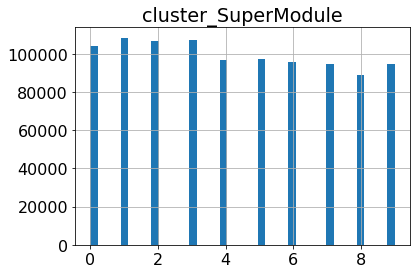

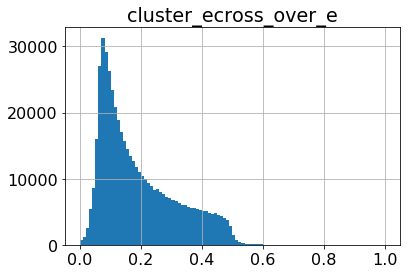

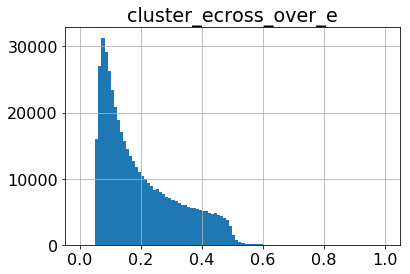

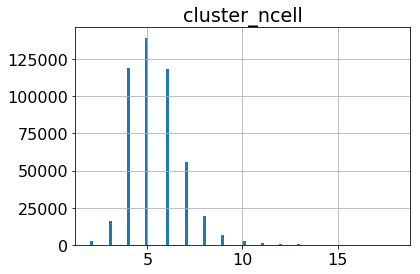

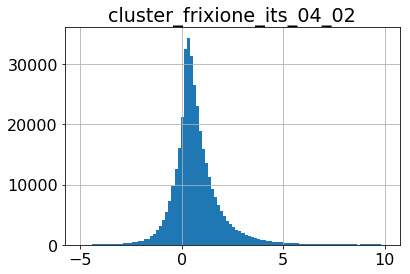

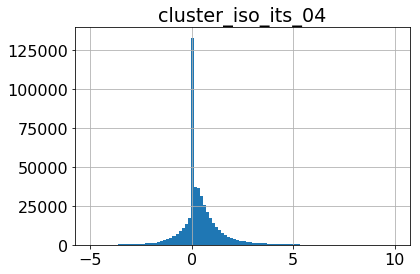

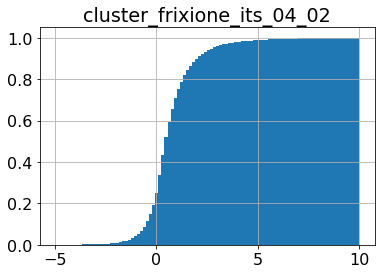

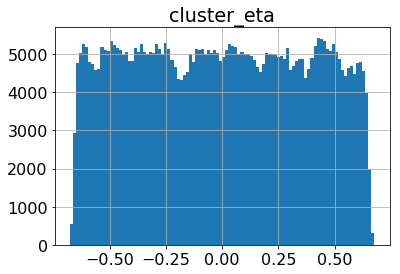

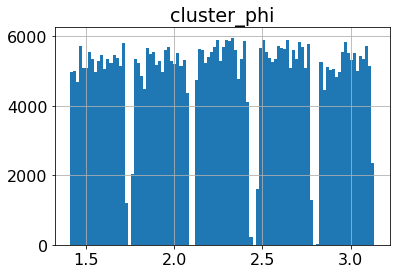

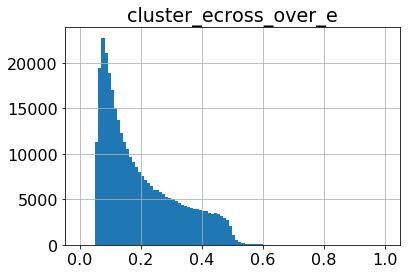

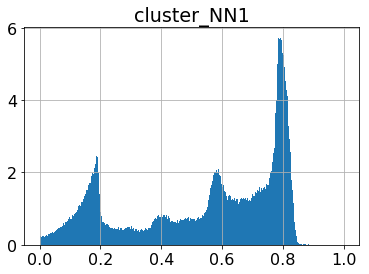

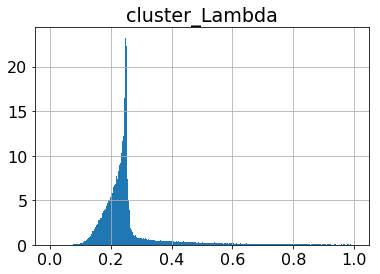

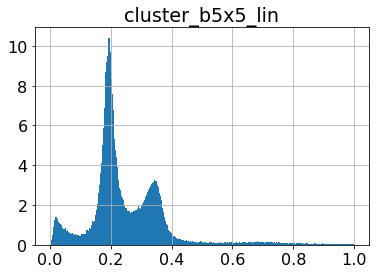

Processed 17g6a1_pthat2_clusterv2_small.root in 30.2319278717 seconds
All: 994430
pt >10.0  GeV : 500254  (50.31  %)
pt <100.0 GeV  : 500254  (100.00  %)
ecross/e > 0.05 : 481759  (96.30  %)
ncell > 2: 479409  (99.51  %)
0<NN1<1.0 : 479409  (100.00  %)
0<NN2<1.0 : 479397  (100.00  %)
Local Maxima < 2 : 479397  (100.00  %)
isolation < 2 GeV: 436185  (90.99  %)
Remove SM#!=3: 431258  (89.96  %)
Remove SM#!=7: 382721  (88.75  %)
isolation < 2 GeV: 348643  (91.10  %)


/root/anaconda2/lib/python2.7/site-packages/root_pandas/readwrite.py:181: FutureWarning:  The option flatten=True is deprecated. Please specify the branches you would like to flatten in a list: flatten=['foo', 'bar']
  "to flatten in a list: flatten=['foo', 'bar']", FutureWarning)


In [11]:
mcFiles = ['17g6a1_pthat2_clusterv2_small.root'] #mcFiles = ['17g6a1_pthat2_clusv2_1run_small.root']
mcFullHists = getData(mcFiles)
print 'All:', mcFullHists.shape[0]
mcHists = applyCuts(mcFullHists)
plt.show()
#print 'After All cuts:', mcHists.shape[0]

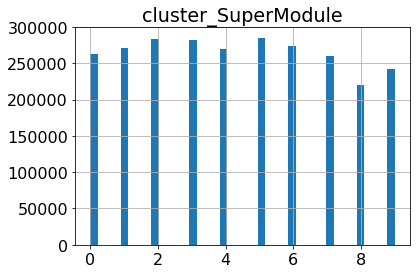

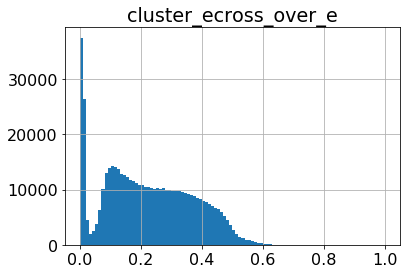

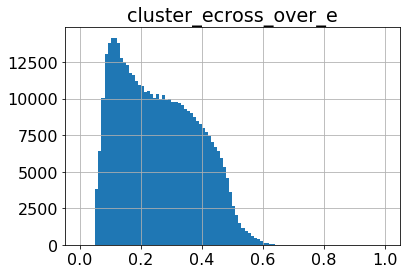

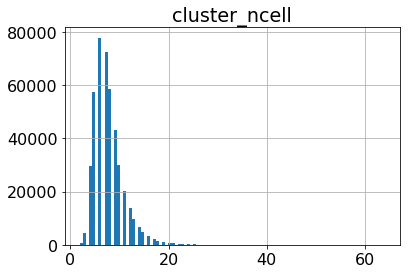

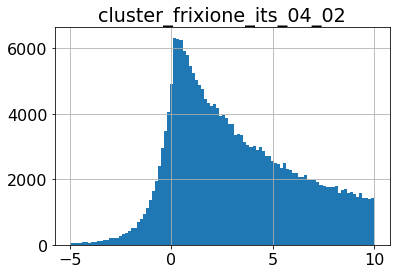

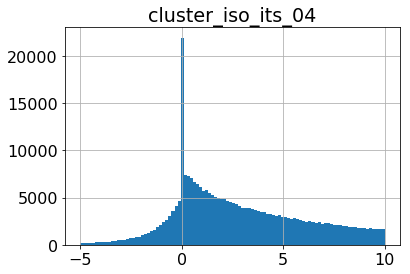

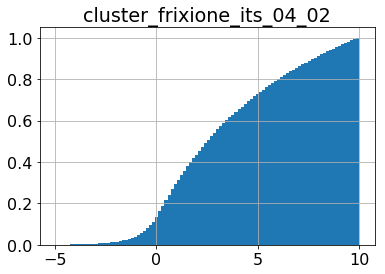

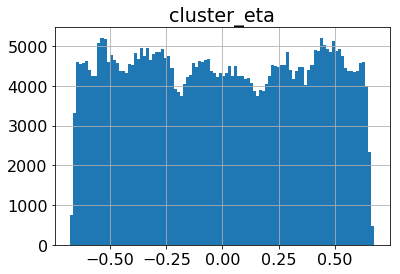

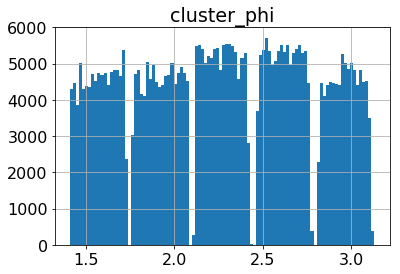

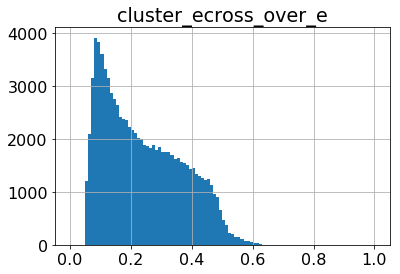

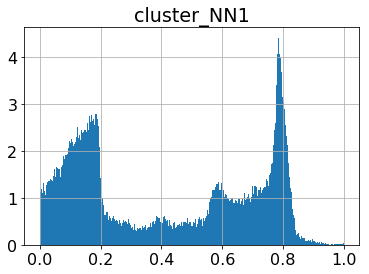

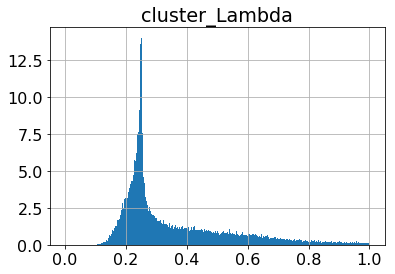

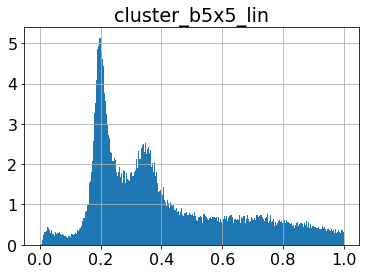

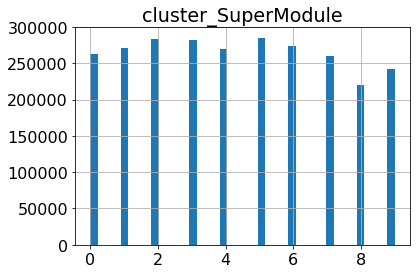

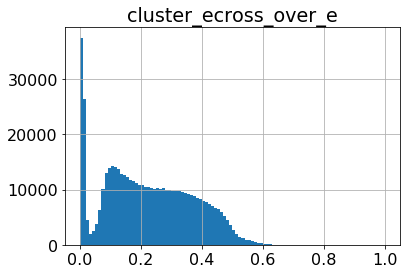

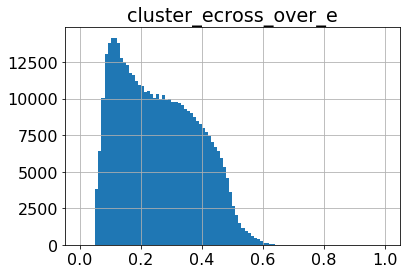

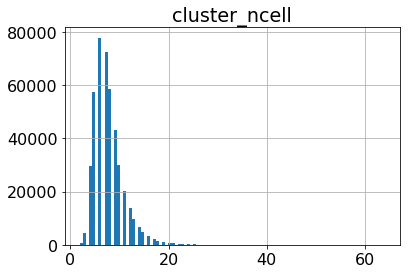

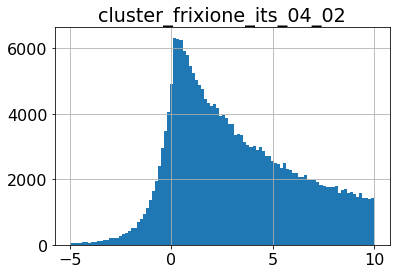

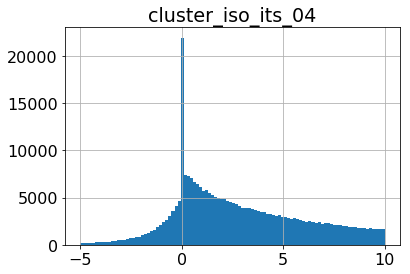

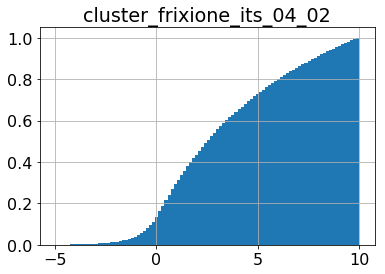

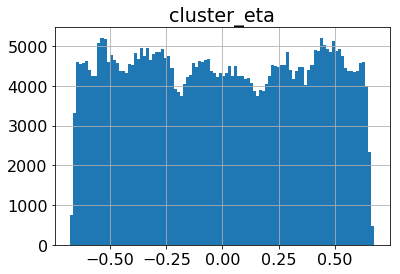

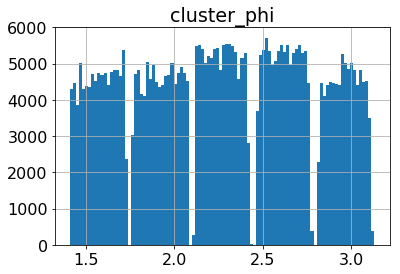

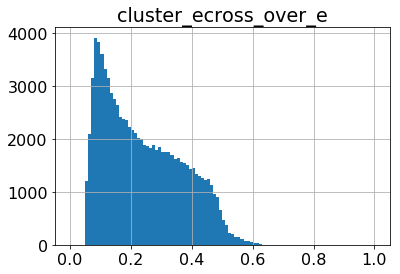

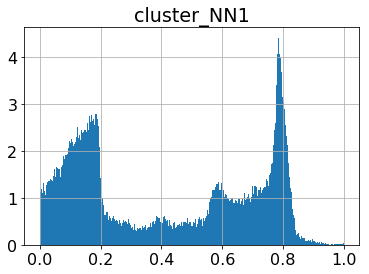

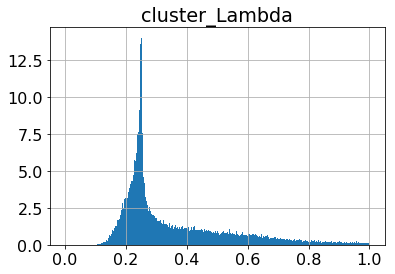

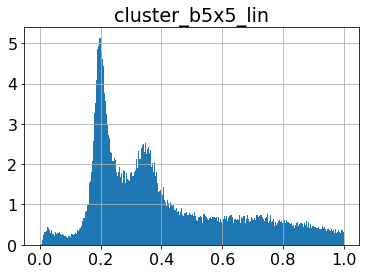

Processed 13def_clusv2_small.root in 32.5903022289 seconds
All: 2648838
pt >10.0  GeV : 516683  (19.51  %)
pt <100.0 GeV  : 513208  (99.33  %)
ecross/e > 0.05 : 440406  (85.81  %)
ncell > 2: 439589  (99.81  %)
0<NN1<1.0 : 439529  (99.99  %)
0<NN2<1.0 : 438703  (99.81  %)
Local Maxima < 2 : 438703  (100.00  %)
isolation < 2 GeV: 115682  (26.37  %)
Remove SM#!=3: 394667  (89.96  %)
Remove SM#!=7: 349033  (88.44  %)
isolation < 2 GeV: 90865  (26.03  %)


/root/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [13]:
dataFiles = ['13def_clusv2_small.root']#['17q_CENT_wSDD_small.root']#['17q_FAST_small.root']#['13def_clusv2_small.root'] #['17q_FAST_small.root']#['13f_clusv1_small.root']#['13def_clusv1_small.root']#['13e_clusterv2_small.root']
dataFullHists = getData(dataFiles)
print 'All:',dataFullHists.shape[0]
dataHists = applyCuts(dataFullHists)
plt.show()

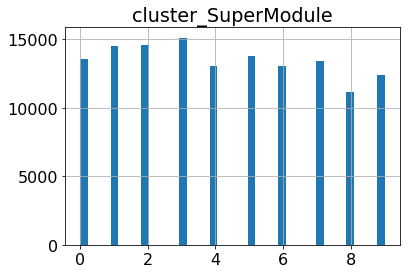

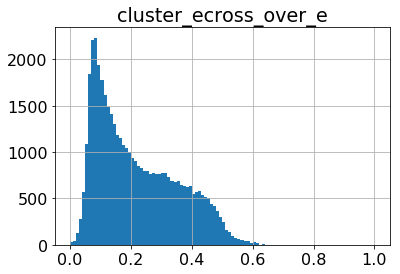

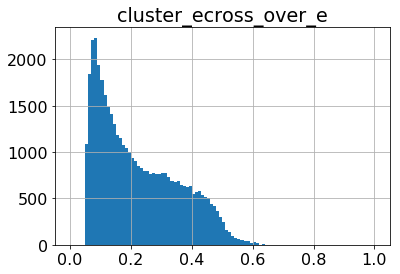

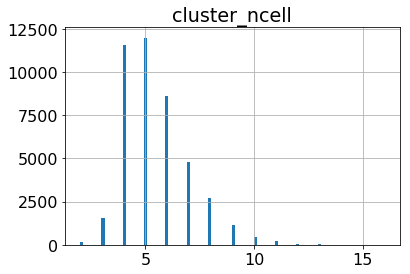

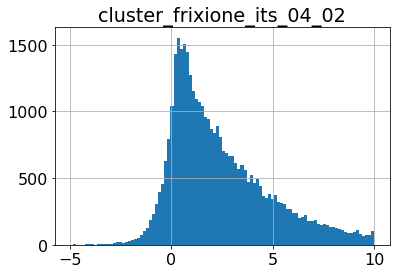

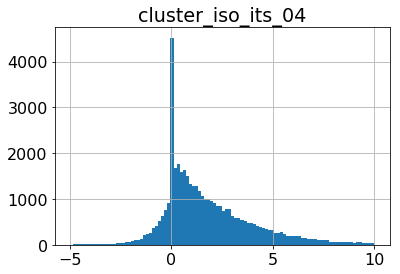

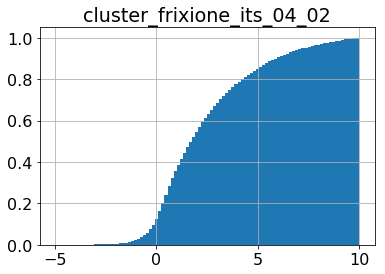

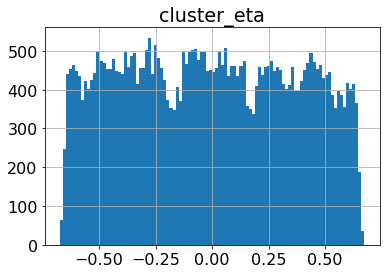

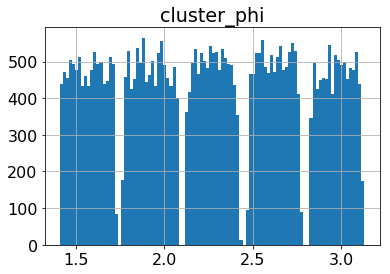

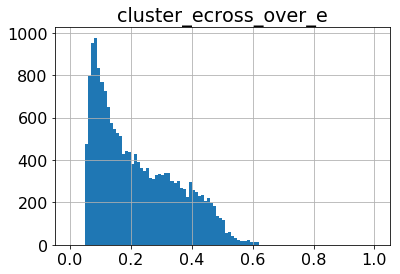

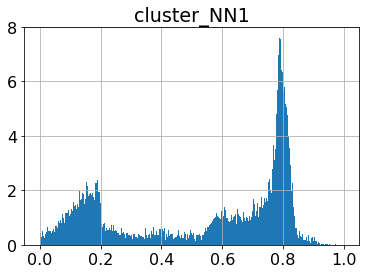

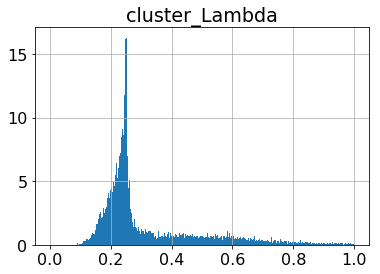

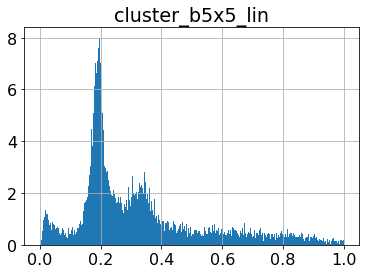

Processed 17g6a3_pthat2_clusterv2_small.root in 4.65230798721 seconds
pt >10.0  GeV : 44190  (32.79  %)
pt <100.0 GeV  : 44190  (100.00  %)
ecross/e > 0.05 : 43145  (97.64  %)
ncell > 2: 42996  (99.65  %)
0<NN1<1.0 : 42996  (100.00  %)
0<NN2<1.0 : 42996  (100.00  %)
Local Maxima < 2 : 42996  (100.00  %)
isolation < 2 GeV: 23542  (54.75  %)
Remove SM#!=3: 38517  (89.58  %)
Remove SM#!=7: 34139  (88.63  %)
isolation < 2 GeV: 18627  (54.56  %)
All: 134762
isolation < 2 GeV: 348643  (91.10  %)
Injected Signal: 348643


In [14]:
dataFiles = ['17g6a3_pthat2_clusterv2_small.root']
dataFullHists = getData(dataFiles)
dataHists = applyCuts(dataFullHists)
print 'All:',dataFullHists.shape[0]
InjectedSignal = applyCut(mcHists, 'cluster_frixione_its_04_02<2', 'isolation < 2 GeV:')
print 'Injected Signal:',InjectedSignal.shape[0]
#dataHists = pd.concat([dataHists ,InjectedSignal[:10000]])
plt.show()

## NN data

In [38]:
bins = 100
fitRange = (0.0, 1.0) #0.05 --0.90
xlabel = 'Deep Neural Network Output'
varname = 'cluster_NN1'
puritymin = 0.55
puritymax = 0.85
limit_yaxis = 10.6


## lambda data

In [90]:
bins = 900
fitRange = (0.0, 1.0)
xlabel = 'Lambda [arb. units]'
varname = 'cluster_Lambda'
limit_yaxis = 20.6
puritymin = 0.0
puritymax = 0.27


## B5x5 data

In [33]:
bins = 200
fitRange = (0.0, 2.0)
xlabel = 'B5x5 [mrad]'
varname = 'cluster_b5x5_lin'
puritymin = 0.0
#puritymax = 0.28
puritymax = 0.5
limit_yaxis = 10.6




## Run template fit over different pt ranges

FCN = 305.61541748 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 3.81469726562e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,N,73915,1,0,0,,,FIXED
2,f,0.248727,0.00589155,0,0,,,


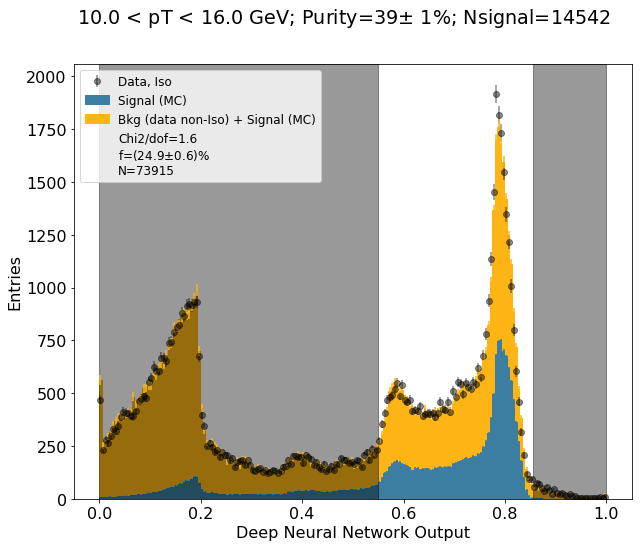

Purity = 0.39010, +0.00747, -0.00754
Purity = 0.39010, +0.00747, -0.00754


In [41]:
#Set isolation variable and ranges: 
isomax=2
nonisorange=(5,15)
isolation = 'cluster_frixione_its_04_02'
#isolation = 'cluster_iso_its_04'
tag = dataFiles[0].split('_small')[0]+isolation

#Set pt bins
#binedges = [10.0,11.0, 12.5, 16.0]#binedges = [10.0,16.0] #binedges = np.logspace(1.0, 1.176, num=5, base=10.0)
binedges = [10,16]
PerSuperModule = False
nsupermodules = 10
SplitEta       = False
cutbadSM      = False


for ipt in range(len(binedges)-1):
    bins = 200
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    title = '%2.1f < pT < %2.1f GeV'%(ptmin, ptmax)
    maskpt_do = dataHists.cluster_pt>ptmin
    maskpt_up = dataHists.cluster_pt<ptmax
    maskdata = maskpt_do & maskpt_up 

    mcmaskpt_do = mcHists.cluster_pt>ptmin
    mcmaskpt_up = mcHists.cluster_pt<ptmax  
    maskmc   = mcmaskpt_do & mcmaskpt_up
    
    
    
    Templates = getTemplates(dataHists[maskdata], mcHists[maskmc], bins,  isocut=isomax, nonisocuts=nonisorange, var = varname, isovar=isolation)
    dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
    tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
    tf.plotFit(xlabel, title, True, puritymin, puritymax,
               normalize=False, figureFilename=varname+'ptmin%2.0f_ptmax%2.0f_%s_Iso%2.0f_Noniso%2.0f_%2.0f.png'%(ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))

     
        
    if(cutbadSM):
        
        Templates = getTemplates(dataHists[maskdata],
                                 mcHists[maskmc], bins,  isocut=isomax, nonisocuts=nonisorange, var = varname, isovar=isolation)
        dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
        tf.plotFit(xlabel, title, True, puritymin, puritymax,
                   figureFilename=varname+'NoSM3or7_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.png'%(ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
    
    
    maskseta_data = [dataHists.cluster_eta>0, dataHists.cluster_eta<0]
    maskseta_mc   = [mcHists.cluster_eta>0, mcHists.cluster_eta<0]
   
    if SplitEta:
        for ieta in range(2):
            Templates = getTemplates(dataHists[maskdata & maskseta_data[ieta]], mcHists[maskmc & maskseta_mc[ieta]], bins,  isocut=isomax, nonisocuts=nonisorange, var = varname, isovar=isolation)
            dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
            tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
            tf.plotFit(xlabel, title, True, puritymin, puritymax,
                       figureFilename=varname+'Eta_%d_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.png'%(ieta,ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
    
    
    if(PerSuperModule):
        bins = 100
        fig = plt.figure(figsize=(24,24))
        for ism in range(nsupermodules ):
            masksm = dataHists.cluster_SuperModule==ism
            plt.subplot(2,nsupermodules/2 ,ism+1)
            plt.hist2d(dataHists[maskdata & masksm].cluster_eta, dataHists[maskdata &masksm].cluster_phi,range=([-.70, .70], [-np.pi, np.pi]),bins=100)
        plt.show()
        fig.tight_layout()
        fig.savefig('supermodules.png')
        for ism in range(nsupermodules):
            mask_supermodules_data = dataHists.cluster_SuperModule==ism
            mask_supermodules_mc   = mcHists.cluster_SuperModule==ism
            maskdata_sm = maskdata & mask_supermodules_data
            maskmc_sm  = maskmc & mask_supermodules_mc
        
            
            Templates = getTemplates(dataHists[maskdata_sm], mcHists[maskmc_sm], bins,  isocut=isomax, nonisocuts=nonisorange, var = varname, isovar=isolation)
            dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates
            tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
            tf.plotFit(xlabel, title, True, puritymin, puritymax,
                       figureFilename=varname+'SuperModule%d_ptmin%2.0f_ptmax%2.0f_%s_Iso_%1.0f_Noniso_%1.0f_%2.0f.png'%(ism,ptmin,ptmax,tag,isomax, nonisorange[0],nonisorange[1]))
        

# Run on test data

FCN = 492.507324219 
 TOTAL NCALL = 19 
 NCALLS = 19 
 
 
 EDM = 1.52587890625e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,N,90865,1,0,0,,,FIXED
2,f,0.294605,0.005021,0,0,,,


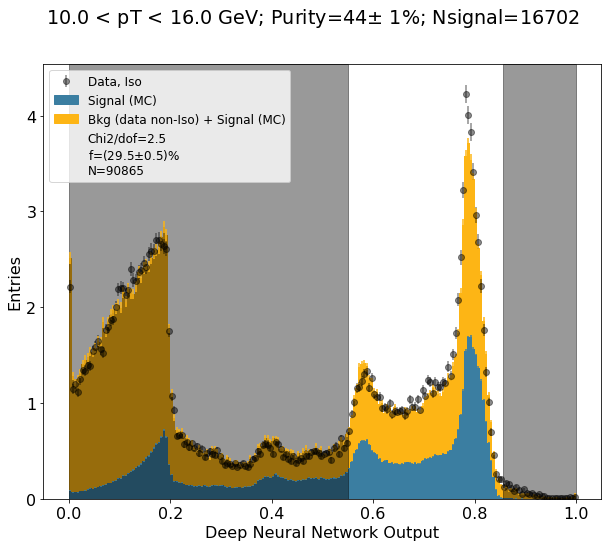

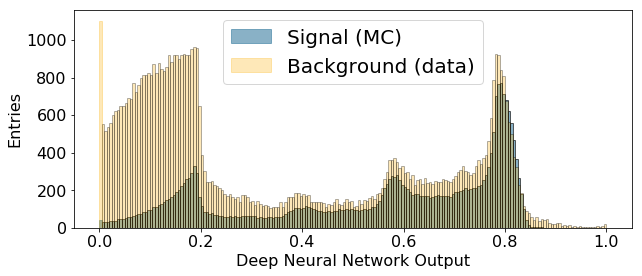

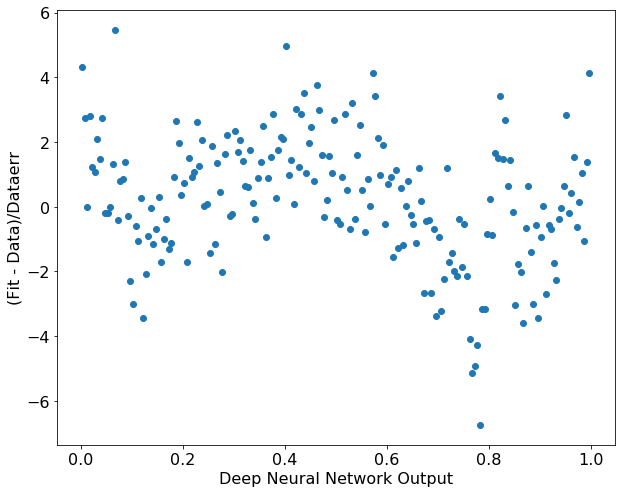

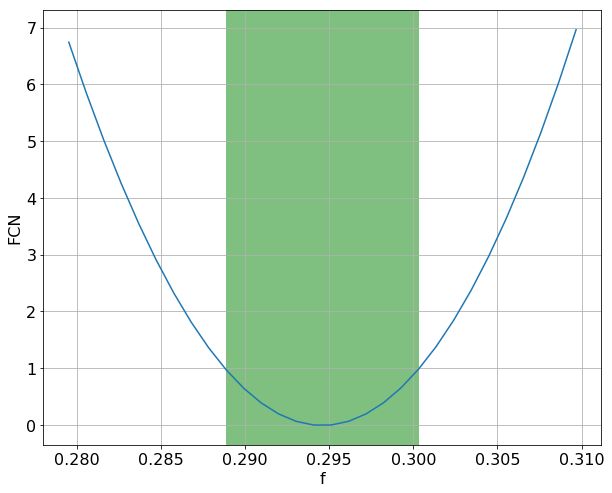

Purity = 0.43727, +0.00592, -0.00597
Purity = 0.43727, +0.00592, -0.00597


In [42]:
# tf = TemplateFit(*nnTemplates, fitRange=(0, 0.90))
Templates = getTemplates(dataHists, mcHists, bins,  isocut=isomax, nonisocuts=nonisorange, var = varname, isovar=isolation)
dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = Templates

tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, fitRange=fitRange)
tf.plotFit(xlabel, title, True, puritymin, puritymax,figureFilename=xlabel+'.png')
tf.plotTemplates(xlabel, figureFilename = 'template_%s.png'%xlabel)
tf.plotResiduals(xlabel, figureFilename='residuals_%s.png'%xlabel)
tf.plotProfile(xlabel, figureFilename='profile_%s.png'%xlabel)
#purity, pmin, pmax = tf.getPurity(puritymin, puritymax)


In [ ]:
calculateFitUncertainty(dataiso, signalmc, datanoniso, binEdges, puritymin, puritymax, fitRange)

In [ ]:
# vary data with poisson distribution in each bin
_ = getFitResults(varyWithinBins(dataiso, 10000), [signalmc], [datanoniso], binEdges,
                         pmin=puritymin, pmax=puritymax, verbosity=0, showDistributions=True)

In [ ]:
plotFitUncertaintyExamples(dataiso, dataisoerr, signalmc, datanoniso, binEdges)

In [ ]:
closureResults = checkClosureOverParameters(dataiso, signalmc, datanoniso, binEdges, 1000)

In [ ]:
plotCheckClosureResults(*closureResults)

# Check effect of binning

In [ ]:
def checkBinEffects(dataHists, mcHists, var, puritymin, puritymax, title, fitRange=None, varRange=(0.0, 1.0)):
    dataisos, dataisoerrs = [], []
    signalmcs, signalmcerrs = [], []
    datanonisos, datanonisoerrs = [], []
    binEdgess = []        
    bins, fracs, fracerrs, purs = [], [], [], []
    
    for nBins in range(20, 401,4):
        dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges = getTemplates(dataHists, mcHists, nBins, var=var)
        
        tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, verbosity=0, fitRange=fitRange)
        bins.append(nBins)
        fracs.append(tf.fitf)
        fracerrs.append(tf.fitferr)
        purs.append(tf.getPurity(puritymin, puritymax)[0])
        
        if (nBins%10 == 0 and nBins <= 100):
            dataisos.append(dataiso)
            dataisoerrs.append(dataisoerr)
            signalmcs.append(signalmc)
            signalmcerrs.append(signalmcerr)
            datanonisos.append(datanoniso)
            datanonisoerrs.append(datanonisoerr)
            binEdgess.append(binEdges)
            
#     plt.figure(figsize=(18,18))
#     for i, (dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges) \
#     in enumerate(zip(dataisos, dataisoerrs, signalmcs, signalmcerrs, datanonisos, datanonisoerrs, binEdgess)):
#         plt.subplot(3,3,i+1)plt.figure(figsize=(18,18))
#         ax = plt.gca()
#         tf = TemplateFit(dataiso, dataisoerr, signalmc, signalmcerr, datanoniso, datanonisoerr, binEdges, verbosity=0, fitRange=fitRange)
#         tf.plotFit('', '', newFigure=False)
#         ax.legend_.remove()
#         ax.set_ylabel('')
#         ax.set_title('nBins: %i, frac: %2.2f, purity: %2.2f'%(len(binEdges)-1,
#                                                               tf.fitf, tf.getPurity(puritymin, puritymax)[0]))
#         ax.title.set_size(16)
#         ax.tick_params(labelsize=12)

    plt.figure(figsize=(12,12))
    plt.errorbar(bins, fracs, fracerrs, fmt='ko', label='Fit signal fraction')
    plt.plot(bins, purs, 'bd', label='Purity')
    plt.xlabel('Number of bins')
    plt.ylim([0.0, 1.0])
    plt.legend(loc='best', fontsize=12, numpoints=1)
    plt.title(title)
    ax = plt.gca()
    #ax.axhspan(np.mean(purs)-0.02, np.mean(purs)+0.02, color='green', alpha=0.2)
    
    plt.show()

In [ ]:
checkBinEffects(dataHists, mcHists, 'cluster_NN1', puritymin, puritymax, 'NN1', fitRange)

In [ ]:
checkBinEffects(dataHists, mcHists, 'cluster_Lambda', 0.0, 0.27, '$\lambda$', None, varRange=(0.0, 2.0))

In [ ]:
checkBinEffects(dataHists, mcHists, 'cluster_b5x5_lin', 0.0, 0.2, 'B5x5', None, varRange=(0.0, 2.0))

In [ ]:
#directory = 'v2-noue-old/'
directory = 'v1-ue-new/'

mcFile = directory + 'mcdata.csv'
dataFile = directory + 'data.csv'

mcdf = pd.read_csv(mcFile)
datadf = pd.read_csv(dataFile)

ptmin = 10
ptmax = 12

def applyCut(inputDataframe, cut, text=None):
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0]
    return cutDataframe

print 'Full MC events:', mcdf.shape[0]
mcHists = applyCut(mcdf, 'cluster_pt>%f and cluster_pt<%f'%(ptmin, ptmax), '%2.1f < pt < %2.1f GeV:'%(ptmin, ptmax))

print 'Full data events:', datadf.shape[0]
dataHists = applyCut(datadf, 'cluster_pt>%f and cluster_pt<%f'%(ptmin, ptmax), '%2.1f < pt < %2.1f GeV:'%(ptmin, ptmax))

In [ ]:
import random

random.sample(range(10), 10)